# Adding Sentiment Scores to Reddit Data Collection

## Part 0: Setup

#### Setup basic utilities

In [47]:
# Import Packages
import pyarrow, os, re, ollama, requests, json, time, subprocess, math
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import yfinance as yf

# Check if running in Google Colab
def is_colab():
    from IPython import get_ipython
    return get_ipython().__class__.__module__ == "google.colab._shell"

## Part 1: Read Collected Reddit Data

In [48]:
# Save the collected data to parquet format
MERGED_PARQUET_PATH = './data/merged-reddit-wsb.parquet'

# Verify that the path exists
if not os.path.exists(MERGED_PARQUET_PATH):
    print(f"Error: The file {MERGED_PARQUET_PATH} does not exist.")
    
# Create a pyarrow schema for the data types.
merged_schema = pyarrow.schema([
    ('title', pyarrow.string()),
    ('upvote_ratio', pyarrow.float64()),
    ('id', pyarrow.string()),
    ('permalink', pyarrow.string()),
    ('num_comments', pyarrow.int64()),
    ('created_utc', pyarrow.float64()),
    ('selftext', pyarrow.string())
])

merged_collection = pd.read_parquet(MERGED_PARQUET_PATH, engine='pyarrow', schema=merged_schema)

In [49]:
# Display the first few rows of the submission collection.
display(merged_collection.head())

,title,upvote_ratio,id,permalink,num_comments,created_utc,selftext
0,Nivea Along,0.67,1k0t4jk,/r/wallstreetbets/comments/1k0t4jk/nivea_along/,5,1.744832e+09,After -7% yesterday and -10% today
1,Powell to Volatile Stock Market: You’re on You...,0.86,1k0unbq,/r/wallstreetbets/comments/1k0unbq/powell_to_v...,2,1.744836e+09,
2,Made back the last Wendy’s paycheck I lost,0.94,1k0tv2y,/r/wallstreetbets/comments/1k0tv2y/made_back_t...,6,1.744834e+09,
3,After market observation. When I finished buyi...,0.72,1k0tnqx,/r/wallstreetbets/comments/1k0tnqx/after_marke...,8,1.744833e+09,https://preview.redd.it/41ilvj6f39ve1.png?widt...
4,Ominous,0.85,1k0thnd,/r/wallstreetbets/comments/1k0thnd/ominous/,110,1.744833e+09,NVIDIA 2024 is starting to rhyme like Cisco 20...


## Part 2: _

In [50]:
nasdawq_tickers = pd.read_parquet('./data/nasdaq_tickers.parquet', engine='pyarrow')
display(nasdawq_tickers.head())

,Symbol,Name,Country,Sector,Industry
0,A,Agilent Technologies Inc. Common Stock,United States,Industrials,Biotechnology: Laboratory Analytical Instruments
1,AA,Alcoa Corporation Common Stock,United States,Industrials,Aluminum
2,AACB,Artius II Acquisition Inc. Class A Ordinary Sh...,United States,None,None
3,AACBR,Artius II Acquisition Inc. Rights,United States,None,None
4,AACBU,Artius II Acquisition Inc. Units,United States,Finance,Blank Checks


In [ ]:
def attribute_ticker_re(post: str) -> str:
    """
    Extracts the longest ticker symbol from a given post text.
    Args:
        post (str): The post text to search for ticker symbols.
    Returns:
        str: The longest ticker symbol found in the post, or None if no valid ticker is found.
    """
    # Find all matches of the pattern in the post
    matches = re.findall(r'(?<!\S)($)?([A-Z]{3,5})(?!\S)', post) #([A-Za-z]{1,5})(-[A-Za-z]{1,2})?
    if matches:
        
        # Return the longest matches that are in the NASDAQ list
        matches = [match for match in matches if match in nasdawq_tickers['Symbol'].values]
        if matches:
            longest_match = max(matches, key=len)
            return longest_match
        
    else:
        return None

In [52]:
# Apply the function to the entire collection
tqdm.pandas()
merged_collection['re_ticker'] = merged_collection.progress_apply(lambda x: attribute_ticker_re(f'{x['title']} {x['selftext']}'), axis=1)

100%|██████████| 54577/54577 [00:27<00:00, 2002.15it/s]


In [53]:
# Provide some details about the ticker extraction
print(f"Number of submissions with ticker: {merged_collection['re_ticker'].notnull().sum()}")
print(f"Number of submissions without ticker: {merged_collection['re_ticker'].isnull().sum()}")
print(f"Proportion of submissions with ticker: {merged_collection['re_ticker'].notnull().sum() / len(merged_collection) * 100:.2f}%")
print(f"Number of unique tickers: {merged_collection['re_ticker'].nunique()}")

# Display the first few rows of the collection with tickers
display(merged_collection[['title', 're_ticker']].head(10))

Number of submissions with ticker: 27155
Number of submissions without ticker: 27422
Proportion of submissions with ticker: 49.76%
Number of unique tickers: 1202


,title,re_ticker
0,Nivea Along,None
1,Powell to Volatile Stock Market: You’re on You...,None
2,Made back the last Wendy’s paycheck I lost,None
3,After market observation. When I finished buyi...,None
4,Ominous,None
5,"Monday Boeing, Tuesday Nivida, Today AMD, Tomo...",AMD
6,Before and After,MSTR
7,"Before, After, and Dr*gs?",MSTR
8,Uranium Yolo,None
9,IBKR $185 C 6/20. What are your thoughts regar...,IBKR


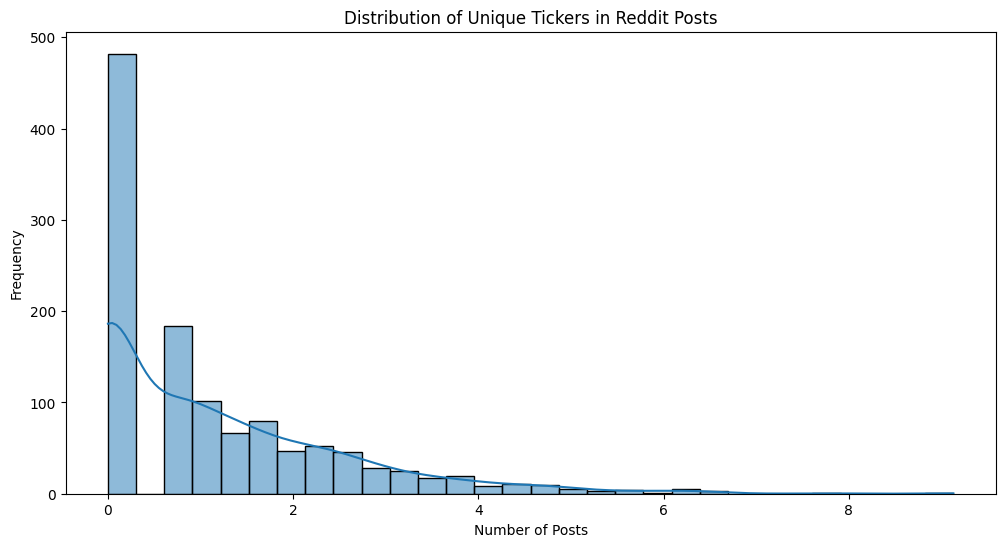

In [54]:
# Show the distribution of unique tickers
ticker_counts = merged_collection['re_ticker'].value_counts()
log_ticker_counts = ticker_counts.apply(lambda x: math.log(x) if x > 0 else 0)
plt.figure(figsize=(12, 6))
sns.histplot(log_ticker_counts, bins=30, kde=True)  
plt.title('Distribution of Unique Tickers in Reddit Posts')
plt.xlabel('Number of Posts')
plt.ylabel('Frequency')
plt.show()

In [55]:
# Show the top 10 most common tickers
top_tickers = ticker_counts.sort_values(ascending=False).head(50)
display(top_tickers)

re_ticker
GME      9210
AMC      2317
PLTR      669
NOK       628
HOOD      623
LINE      535
EDIT      487
RKT       485
TSLA      454
YOU       444
UWMC      367
SNDL      311
ADD       273
CLOV      258
SPCE      253
ARE       220
ALL       203
FOR       180
AMD       161
ING       148
TLRY      141
CRSR      140
MVIS      131
CAN       129
AAPL      126
CLNE      124
NOW       123
LOVE      122
PSA       115
NEXT      112
CLF       108
WKHS      102
AAL        98
NIO        95
ASO        95
NVDA       90
BABA       89
REAL       85
AMZN       84
IONS       82
SOFI       78
GOOD       76
USA        73
OPEN       72
IBKR       70
DKNG       69
OUT        64
CASH       63
WTF        63
GOOGL      61
Name: count, dtype: int64

## Part 3: Create functionality to use ollama

In [56]:
def check_ollama_serve():
    """
    Checks if the Ollama server is running and returns the base URL.
    """
    try:
        # Check if the server is running
        response = requests.get("http://localhost:11434")
        if response.status_code == 200:
            print("Ollama server is running.")
            return "http://localhost:11434"
        else:
            print("Ollama server is not running.")
            return None
    except requests.exceptions.ConnectionError:
        print("Ollama server is not running.")
        return None
    

def start_ollama_serve():
    """
    Starts the Ollama server and returns the base URL.
    """
    try:
        # Check if the server is already running
        requests.get("http://localhost:11434")
        print("Ollama server is already running.")
        return None, "http://localhost:11434"
    except requests.exceptions.ConnectionError:
        # Start the server if it's not running
        process = subprocess.Popen(["ollama", "serve"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        time.sleep(5)
        print("Ollama server started.")
        
        return process, "http://localhost:11434"
         
def stop_ollama_service():
    """
    Stops the Ollama server if it is running.
    """
    try:
        # Check if the server is running
        response = requests.get("http://localhost:11434")
        if response.status_code == 200:
            # Stop the server
            subprocess.run(["pkill", "-f", "ollama"], check=True)
            print("Ollama server stopped.")
        else:
            print("Ollama server is not running.")
    except requests.exceptions.ConnectionError:
        print("Ollama server is not running.")

In [57]:
# Start the Ollama server
ollama_process, base_url = start_ollama_serve()

# Check if the server is running
check_ollama_serve()

Ollama server started.
Ollama server is running.


'http://localhost:11434'

In [58]:
# Stop the Ollama server
stop_ollama_service()

# Check if the server is running
check_ollama_serve()

Ollama server stopped.
Ollama server is not running.


In [59]:
def attribute_ticker_ollama(post: str) -> str:
    """
    Extracts the ticker symbol from the submission text.
    """
    response = ollama.chat(
        model='smollm:360m', # Subject to change.
        messages=[{
            'role': 'user', 
            'content': f'what is the stock ticker for this text "{post}" you have to answer in one word with no period. If you cant determine it just ourput None. Also if there is no text provided output None.'
        }]
    )
    if len(response['message']['content']) > 5:
        response['message']['content'] = 'None'
    return response['message']['content']

## Part 4: Test the ollama attribution

In [60]:
# Get five submissions from the collection
sample_submissions = merged_collection.sample(10, random_state=42)
display(sample_submissions)

,title,upvote_ratio,id,permalink,num_comments,created_utc,selftext,re_ticker
32995,My prediction for the future of Wallstreet bets.,16.0,ldwcr9,https://www.reddit.com/r/wallstreetbets/commen...,15,1.612642e+09,**TL;DR: the some media-companys will probably...,None
31935,Damn. What a fucked up world eh guys?,31.0,ldiwjk,https://i.redd.it/5cqbkc81iqf61.jpg,25,1.612592e+09,None,None
46909,My Predictions for NIO Q1 Earnings and Results,41.0,n15j46,https://www.reddit.com/r/wallstreetbets/commen...,40,1.619735e+09,"I previously posted this, with typos and other...",NIO
47671,Monster Crash,53689.0,n5lboc,https://v.redd.it/shekh7yq5cx61,1156,1.620264e+09,None,None
11993,So,1.0,l71b7v,https://www.reddit.com/r/wallstreetbets/commen...,7,1.611880e+09,How much money have ya’ll lost in the last hour?,None
33797,TDC - deeper DD as promised,236.0,lfulsm,https://www.reddit.com/r/wallstreetbets/commen...,174,1.612874e+09,**TLDR**; TDC is a better Snowflake worth $70 ...,ORCL
41293,What could be better for GME transition to onl...,3296.0,m0oxdf,https://www.reddit.com/r/wallstreetbets/commen...,194,1.615263e+09,"Who buys more video games, a hedge fund or ten...",GME
49098,Buy the rumor sell the news...,70.0,nmhjn3,https://i.redd.it/2oh0ye679q171.jpg,27,1.622178e+09,None,None
24634,"Losses are mounting$GME, $AMC but I might as w...",140.0,layr40,https://i.redd.it/p26msql063f61.jpg,8,1.612310e+09,None,GME
19224,Feel the Squeeze,117.0,l8t5sw,https://i.redd.it/ihybwj6drie61.gif,20,1.612063e+09,None,None


In [61]:
## Provide example usage
# Start the Ollama server
ollama_process, base_url = start_ollama_serve()

# Display the sample submissions
for submission in tqdm(sample_submissions.iterrows()):
    submission = submission[1]
    post_text = submission['title']
    print('Post:', post_text)
    print('Ticker:', attribute_ticker_ollama(post_text))
    print('-' * 50)
    
# Stop the Ollama server
stop_ollama_service()

# Check if the server is running
check_ollama_serve()

Ollama server started.


0it [00:00, ?it/s]

Post: My prediction for the future of Wallstreet bets.


1it [00:01,  1.84s/it]

Ticker: None
--------------------------------------------------
Post: Damn. What a fucked up world eh guys?


2it [00:02,  1.08it/s]

Ticker: None
--------------------------------------------------
Post: My Predictions for NIO Q1 Earnings and Results


3it [00:03,  1.17s/it]

Ticker: None
--------------------------------------------------
Post: Monster Crash


4it [00:03,  1.26it/s]

Ticker: None
--------------------------------------------------
Post: So


5it [00:04,  1.57it/s]

Ticker: None
--------------------------------------------------
Post: TDC - deeper DD as promised


6it [00:04,  1.45it/s]

Ticker: None
--------------------------------------------------
Post: What could be better for GME transition to online retailer than a massive story and the loyalty of tens of thousands of Redditors having a life changing experience with them?


7it [00:06,  1.12it/s]

Ticker: None
--------------------------------------------------
Post: Buy the rumor sell the news...


8it [00:06,  1.37it/s]

Ticker: None
--------------------------------------------------
Post: Losses are mounting$GME, $AMC but I might as well hold - if nothing else I can gift it to my son in March 💎🙏🏼🚀🚀🚀


9it [00:06,  1.66it/s]

Ticker: None
--------------------------------------------------
Post: Feel the Squeeze


10it [00:07,  1.39it/s]

Ticker: None
--------------------------------------------------
Ollama server stopped.
Ollama server is not running.


## Part 5: Use the ollama attribution

In [62]:
# # Start the Ollama server
# ollama_process, base_url = start_ollama_serve()

# # Apply the function to the entire collection
# tqdm.pandas()
# merged_collection['llm_ticker'] = merged_collection.progress_apply(lambda x: attribute_ticker_ollama(f'{x['title']} {x['selftext']}'), axis=1)

# # Stop the Ollama server
# stop_ollama_service()

# # Check if the server is running
# check_ollama_serve()

In [63]:
# # Provide some details about the ticker extraction
# print(f"Number of submissions with ticker: {merged_collection['llm_ticker'].notnull().sum()}")
# print(f"Number of submissions without ticker: {merged_collection['llm_ticker'].isnull().sum()}")
# print(f"Proportion of submissions with ticker: {merged_collection['llm_ticker'].notnull().sum() / len(merged_collection) * 100:.2f}%")
# print(f"Number of unique tickers: {merged_collection['llm_ticker'].nunique()}")

# # Display the first few rows of the collection with tickers
# display(merged_collection[['title', 'llm_ticker']].head(10))